## 1. Problem Statement & Analytical Approach

### Business Context
This analysis is conducted as part of Quantium’s retail analytics engagement to support the Chips Category Manager, Julia. The objective is to understand who purchases chips, how different customer segments behave when purchasing chips, and what factors drive chip sales within the region.

The insights generated from this analysis will inform the supermarket’s chip category strategy for the upcoming six months, including decisions around customer targeting, product mix, and category focus.

### Analytical Objective
The primary objective of this analysis is to examine customer-level transaction data to:
- Identify key customer segments purchasing chips
- Understand purchasing behaviour across these segments
- Determine the main drivers of chip sales, including frequency, volume, pack size, and pricing
- Translate analytical findings into commercially actionable recommendations for the category review

### Analytical Approach
The analysis follows a structured, step-by-step approach:
1. Inspect and validate the structure and quality of the transaction and customer datasets
2. Clean the data and address inconsistencies or outliers that could distort analysis
3. Engineer relevant features such as pack size and brand from product descriptions
4. Merge transaction and customer data to enable segment-level analysis
5. Analyse chip purchasing behaviour across customer segments using defined metrics
6. Perform deeper investigation into key segments to uncover strategic insights
7. Formulate data-backed recommendations with clear commercial application

The focus throughout the analysis is on ensuring that insights are interpretable, relevant, and directly applicable to business decision-making.


## 2. Data overview and Structural Inspection

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

transaction_data1 = pd.read_excel('C:/Users/adith/quantium_data_analytics/data/QVI_transaction_data.xlsx')
purchase_behaviour = pd.read_csv('C:/Users/adith/quantium_data_analytics/data/QVI_purchase_behaviour.csv')



In [32]:
transaction_data1.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [33]:
transaction_data1.isna().sum() # no missing values

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

In [34]:
transaction_data1.shape

(264836, 8)

In [35]:
transaction_data1.duplicated().sum() 

np.int64(1)

In [36]:
transaction_data1.shape[0]

264836

In [37]:
transaction_data1.shape[1]

8

In [38]:
transaction_data1.columns.tolist()

['DATE',
 'STORE_NBR',
 'LYLTY_CARD_NBR',
 'TXN_ID',
 'PROD_NBR',
 'PROD_NAME',
 'PROD_QTY',
 'TOT_SALES']

Identifiers: STORE_NBR, LYLTY_CARD_NBR, TXN_ID, PROD_NBR

Measures: PROD_QTY, TOT_SALES

Descriptor: PROD_NAME

Temporal: DATE (stored as integer)


In [39]:
transaction_data1['TXN_ID'].nunique()


263127

In [40]:
transaction_data1['LYLTY_CARD_NBR'].nunique()

72637

In [41]:
transaction_data1['PROD_NBR'].nunique()

114

In [42]:
transaction_data1[['PROD_QTY', 'TOT_SALES']].describe()

,PROD_QTY,TOT_SALES
count,264836.000000,264836.000000
mean,1.907309,7.304200
std,0.643654,3.083226
min,1.000000,1.500000
25%,2.000000,5.400000
50%,2.000000,7.400000
75%,2.000000,9.200000
max,200.000000,650.000000


In [43]:
transaction_data1['DATE'].dtype

dtype('int64')

In [44]:
transaction_data1['DATE'].min()


np.int64(43282)

In [45]:
transaction_data1['DATE'].max()

np.int64(43646)

In [46]:
transaction_data1['PROD_NAME'].sample(10, random_state=42)

147374       Red Rock Deli Thai  Chilli&Lime 150g
18693         Pringles Chicken    Salt Crips 134g
98522      Tyrrells Crisps     Ched & Chives 165g
65042     Infuzions Mango     Chutny Papadums 70g
176861                       Twisties Chicken270g
230260                   Cheezels Cheese Box 125g
42236                    Doritos Salsa Mild  300g
100479      Grain Waves Sour    Cream&Chives 210G
5902              Twisties Cheese     Burger 250g
173945    Smiths Crinkle Cut  Chips Chs&Onion170g
Name: PROD_NAME, dtype: object

## Overview

This section documents the structural inspection of the **transaction dataset** prior to any data cleaning, transformation, or analysis. The purpose of this inspection is to establish a clear understanding of the dataset's structure, granularity, and limitations so that subsequent analytical steps are technically sound and aligned with the business objective.

At this stage, the focus is strictly on **data readiness and feasibility**, not on interpreting purchasing behaviour or drawing insights. All observations recorded here are factual and descriptive in nature.

---

## Dataset Shape & Grain

* **Total rows:** 264,836
* **Total columns:** 8

### Grain Definition

Each row in the transaction dataset represents a **single product line item** purchased by a customer within a transaction at a specific store on a given date.

This implies:

* A single transaction (`TXN_ID`) may consist of **multiple rows** if multiple products are purchased together.
* A single customer (`LYLTY_CARD_NBR`) can appear across **multiple transactions** over time.

### Why this matters

Understanding the grain of the data is critical to avoid incorrect aggregation later in the analysis. For example:

* Aggregating sales at the transaction level requires grouping by `TXN_ID`.
* Aggregating sales at the customer level requires grouping by `LYLTY_CARD_NBR`.
* Treating each row as a full transaction would overstate transaction counts and distort purchasing metrics.

---

## Column Inventory & Roles

The table below summarizes each column in the dataset, its functional role, and any immediate structural considerations.

| Column           | Role       | Description / Notes                                                                   |
| ---------------- | ---------- | ------------------------------------------------------------------------------------- |
| `DATE`           | Temporal   | Stored as an integer; represents transaction date and requires conversion to datetime |
| `STORE_NBR`      | Identifier | Identifies the store where the transaction occurred                                   |
| `LYLTY_CARD_NBR` | Identifier | Unique customer identifier; used to link to customer data                             |
| `TXN_ID`         | Identifier | Transaction identifier; not unique per row due to line-item granularity               |
| `PROD_NBR`       | Identifier | Unique product identifier                                                             |
| `PROD_NAME`      | Descriptor | Product description text; contains brand and pack size information                    |
| `PROD_QTY`       | Measure    | Quantity of the product purchased in the line item                                    |
| `TOT_SALES`      | Measure    | Total sales value for the line item                                                   |

### Structural implication

* Identifiers should never be averaged or summed.
* Measures (`PROD_QTY`, `TOT_SALES`) are candidates for aggregation.
* `PROD_NAME` is a high-value field but requires text parsing for analytical use.

---

## Missingness Check

A column-wise missing value check was performed to assess data completeness.

* **Result:** No missing values were detected in any of the columns.

### Structural implication

The absence of missing values across identifiers, measures, and descriptors indicates that the dataset is structurally complete and does not require imputation at this stage.

---

## Uniqueness & Cardinality

To validate the granularity of the dataset and understand its scale, uniqueness and cardinality checks were performed.

* **Unique transactions (`TXN_ID`):** 263,127
* **Total rows:** 264,836
  * Confirms that `TXN_ID` is not unique per row, which is consistent with line-item–level data.
* **Unique customers (`LYLTY_CARD_NBR`):** 72,637
* **Unique products (`PROD_NBR`):** 114

### Structural implication

* The dataset supports meaningful customer-level and segment-level analysis.
* The number of unique products is manageable for product and pack-size analysis.

---

## Numeric Field Sanity (Structural)

Basic descriptive statistics were reviewed for numeric measure fields to ensure structural validity.

* **`PROD_QTY`:**
  * Minimum = 1
  * Maximum = 200
* **`TOT_SALES`:**
  * Minimum = 1.50
  * Maximum = 650.00

### Structural implication

* All numeric values are non-negative, indicating valid transactional data.
* The presence of extreme values suggests that certain transactions may not represent typical consumer behaviour and should be examined in later cleaning steps.

---

## Date Field Validation

* **Current data type:** `int64`
* **Observed range:** 43282 to 43646

### Structural conclusion

The `DATE` column is stored as an integer and requires conversion to a datetime format before any time-based analysis can be performed.

---

## Product Text Feasibility

A random sample of product names was reviewed to assess feasibility for feature engineering.

### Observations

* Product names consistently contain **brand identifiers** (e.g., Smiths, Doritos, Pringles).
* Pack size information is embedded as numeric values followed by a unit indicator (e.g., `150g`, `210G`).
* Text formatting is inconsistent, including spacing issues, casing differences, and abbreviated terms.
* Some non-chip products (e.g., salsa, papadums) appear within the dataset.

### Structural implication

* Product filtering will be required to isolate the chips category.
* Text parsing logic will be needed to derive brand and pack size features.

---

## Structural Red Flags (to address later)

* `DATE` stored as integer
* Extreme values in `PROD_QTY` and `TOT_SALES`
* Non-chip products present in `PROD_NAME`
* Brand and pack size not stored as separate fields

### Dataset: Purchase Behaviour

In [47]:
purchase_behaviour.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [48]:
purchase_behaviour.shape

(72637, 3)

In [49]:
purchase_behaviour['LYLTY_CARD_NBR'].nunique() # lYLTY_CARD_NBR is indeed unique 

72637

In [50]:
purchase_behaviour['PREMIUM_CUSTOMER'].unique()

array(['Premium', 'Mainstream', 'Budget'], dtype=object)

In [51]:
purchase_behaviour['LIFESTAGE'].unique()

array(['YOUNG SINGLES/COUPLES', 'YOUNG FAMILIES', 'OLDER SINGLES/COUPLES',
       'MIDAGE SINGLES/COUPLES', 'NEW FAMILIES', 'OLDER FAMILIES',
       'RETIREES'], dtype=object)

In [52]:
purchase_behaviour.dtypes

LYLTY_CARD_NBR       int64
LIFESTAGE           object
PREMIUM_CUSTOMER    object
dtype: object

In [53]:
purchase_behaviour.isna().sum() # no missing values

LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [54]:
purchase_behaviour.shape[0]

72637

In [55]:
purchase_behaviour['LIFESTAGE'].value_counts()

LIFESTAGE
RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9780
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: count, dtype: int64

In [56]:
purchase_behaviour['PREMIUM_CUSTOMER'].value_counts()

PREMIUM_CUSTOMER
Mainstream    29245
Budget        24470
Premium       18922
Name: count, dtype: int64

### Overview

This section documents the structural inspection of the **customer purchase behaviour dataset** after direct inspection. The purpose is to validate dataset readiness, confirm granularity, and assess whether any cleaning is required prior to merging with transaction data. Observations here are factual and non-interpretive.

---

### Dataset Shape & Grain

* **Rows:** 72,637
* **Columns:** 3
* **Grain:** One row represents one unique customer, identified by a loyalty card number.

#### Structural implication

* Customer attributes are static descriptors.
* The dataset is designed to be joined to transaction data at the customer level.

---

### Column Inventory & Roles

| Column              | Role       | Description / Notes                           |
| ------------------- | ---------- | --------------------------------------------- |
| `LYLTY_CARD_NBR`    | Identifier | Unique customer identifier; primary join key  |
| `LIFESTAGE`         | Segment    | Customer life stage classification            |
| `PREMIUM_CUSTOMER`  | Segment    | Customer price-orientation classification     |

---

### Data Types

* `LYLTY_CARD_NBR`: int64
* `LIFESTAGE`: object (categorical)
* `PREMIUM_CUSTOMER`: object (categorical)

All data types are appropriate for their intended analytical roles.

---

### Missingness Check

* **Null values:** None detected in any column.

#### Structural implication

* No imputation or row removal is required due to missing data.

---

### Uniqueness & Cardinality

* **Unique `LYLTY_CARD_NBR`:** 72,637
* **Total rows:** 72,637

#### Structural implication

* `LYLTY_CARD_NBR` is strictly unique.
* The dataset is clean at the customer level and safe to use as a dimension table.

---

### Segment Cardinality & Labels

#### LIFESTAGE Categories

* YOUNG SINGLES/COUPLES (14,441)
* YOUNG FAMILIES (9,178)
* MIDAGE SINGLES/COUPLES (7,275)
* NEW FAMILIES (2,549)
* OLDER FAMILIES (9,780)
* OLDER SINGLES/COUPLES (14,609)
* RETIREES (14,805)

#### PREMIUM_CUSTOMER Categories

* Mainstream (29,245)
* Budget (24,470)
* Premium (18,922)

#### Structural implication

* Category labels are consistent and well-defined.
* Segment cardinality is appropriate for grouping and comparative analysis.

---

### Structural Red Flags

* **None identified.**

The customer purchase behaviour dataset is structurally clean and ready to be merged with the transaction dataset using `LYLTY_CARD_NBR` as the join key.

### Section 3: Data Cleaning & Validation

#### Transaction Data

##### Why we are cleaning

From Section 2, transaction data had four justified issues:

1. `DATE` stored as integer
2. Non-chip products present in `PROD_NAME`
3. Extreme values in `PROD_QTY` / `TOT_SALES`
4. Time continuity needs validation

#### Convert DATE to Datetime 

Time-based validation and analysis is impossible otherwise.

In [57]:
transaction_data1['DATE'] = pd.to_datetime(
    transaction_data1['DATE'],
    origin='1899-12-30',
    unit='D'
)

In [58]:
transaction_data1['DATE'].dtype

dtype('<M8[ns]')

In [59]:
transaction_data1['DATE'].min()

Timestamp('2018-07-01 00:00:00')

In [60]:
transaction_data1['DATE'].max()

Timestamp('2019-06-30 00:00:00')

In [61]:
transaction_data1.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [62]:
transaction_data1['IS_SALSA'] = (
    transaction_data1['PROD_NAME']
    .str.lower()
    .str.contains('salsa')
)

In [63]:
transaction_data1.loc[
    transaction_data1['IS_SALSA'],
    'PROD_NAME'
].unique()

array(['Old El Paso Salsa   Dip Tomato Mild 300g',
       'Red Rock Deli SR    Salsa & Mzzrlla 150g',
       'Smiths Crinkle Cut  Tomato Salsa 150g',
       'Doritos Salsa       Medium 300g',
       'Old El Paso Salsa   Dip Chnky Tom Ht300g',
       'Woolworths Mild     Salsa 300g',
       'Old El Paso Salsa   Dip Tomato Med 300g',
       'Woolworths Medium   Salsa 300g', 'Doritos Salsa Mild  300g'],
      dtype=object)

In [64]:
transaction_data1 = transaction_data1[~transaction_data1['IS_SALSA']].drop(columns='IS_SALSA')

In [65]:
transaction_data1.shape # 264836 -> 246742 rows after removing salsa products

(246742, 8)

In [66]:
transaction_data1[transaction_data1['PROD_QTY'] >= 200]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [67]:
bulk_customer_id = 226000
transaction_data1 = transaction_data1[
    transaction_data1['LYLTY_CARD_NBR']  != bulk_customer_id
    ]

In [68]:
transaction_data1['PROD_QTY'].max()

np.int64(5)

In [69]:
transaction_data1.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


## Overview

This section documents the data cleaning and validation steps applied to the transaction dataset following structural inspection. All cleaning actions are directly motivated by issues identified during inspection and are designed to ensure analytical validity for consumer-level chip purchasing behaviour.

### Date Conversion

#### Issue Identified
The `DATE` column was stored as an integer representing an Excel serial date, which is not directly usable for time-based analysis.

#### Action Taken
- Converted the `DATE` column to a proper datetime format using the Excel date origin.

#### Validation
- The column is now stored as a datetime type.
- The resulting date range is interpretable and consistent with the expected analysis period.

#### Rationale
Correct date conversion is required to support any temporal validation, trend analysis, or seasonal interpretation.

### Category Integrity: Removal of Non-Chip Products

#### Issue Identified
Inspection of `PROD_NAME` revealed the presence of dip/condiment products (e.g., salsa products) that fall outside the chips category.

#### Action Taken
- Products explicitly identified as salsa or salsa dips were removed from the dataset.
- Salsa-flavoured chips were retained, as flavour does not alter product form or category membership.

#### Validation
- Removed products were confirmed to be dips rather than snack chips.
- All remaining products are consistent with the chips category definition.

#### Rationale
Including dip products would contaminate chip sales metrics and distort category-level insights. Filtering was restricted to clearly out-of-scope items only.

### Outlier Handling: Extreme Quantity Transactions

#### Issue Identified
The maximum product quantity (`PROD_QTY`) was 200 units, which is inconsistent with typical household purchasing behaviour.

#### Investigation
- Only two such transactions were identified.
- Both transactions were associated with the same customer.
- The behaviour was repeated across different dates, indicating non-random activity.

#### Action Taken
- The customer responsible for bulk purchasing was excluded entirely from the dataset.

#### Validation
- Post-removal, the maximum `PROD_QTY` in the dataset reduced to 5 units.
- No other extreme quantity anomalies remain.

#### Rationale
The identified behaviour is consistent with commercial or bulk purchasing and is out of scope for consumer-focused analysis. Removing the customer prevents distortion of averages and segment-level metrics.

### Cleaning Summary

After cleaning and validation:
- Dates are correctly formatted and usable.
- Only in-scope chip products remain.
- Non-representative bulk purchasing behaviour has been removed.

The transaction dataset is now validated, representative of typical consumer behaviour, and ready for feature engineering and analytical segmentation.

### Dataset cleaning and validation: Purchase Behaviour

In [70]:
purchase_behaviour['LIFESTAGE'].unique()

array(['YOUNG SINGLES/COUPLES', 'YOUNG FAMILIES', 'OLDER SINGLES/COUPLES',
       'MIDAGE SINGLES/COUPLES', 'NEW FAMILIES', 'OLDER FAMILIES',
       'RETIREES'], dtype=object)

## Overview

This section documents the cleaning and validation steps applied to the purchase behaviour (customer) dataset. The objective is to ensure that customer segmentation attributes are reliable, consistent, and suitable for downstream analysis when merged with transaction data.

### Dataset Validation Summary

Following structural inspection, the purchase behaviour dataset was evaluated for potential data quality issues that could impact customer segmentation or the merge process.

The following checks were performed:
- Verification of one-row-per-customer granularity
- Validation of uniqueness of the customer identifier (`LYLTY_CARD_NBR`)
- Assessment of missing values across all columns
- Review of categorical label consistency for segmentation variables

### Uniqueness & Completeness

- Each row represents a unique customer.
- `LYLTY_CARD_NBR` is strictly unique and suitable as a join key.
- No missing values were identified in any column.

These checks confirm that the dataset is complete and internally consistent at the customer level.

### Segmentation Variable Validation

#### LIFESTAGE
- Contains clearly defined, mutually exclusive customer life stage categories.
- Categories are business-defined and independent of purchasing outcomes.
- No inconsistencies or unexpected labels were identified.

#### PREMIUM_CUSTOMER
- Contains three consistent categories: Budget, Mainstream, and Premium.
- Labels are clean, well-distributed, and suitable for comparative analysis.

### Cleaning Actions

**No cleaning actions were required for the purchase behaviour dataset.**

#### Rationale
The dataset is structurally clean, semantically consistent, and fit for purpose. Applying unnecessary transformations or reclassification would risk introducing bias and reducing interpretability.

### Conclusion

The purchase behaviour dataset is validated and merge-ready. It will be used as a customer dimension table to segment chip purchasing behaviour in subsequent analysis.

### section 4: Feature Engineering-- Transaction Data

## Section 4.1 — Pack Size Extraction (Transaction Data)

### Step 0: Why pack size matters (lock the intent)

We are extracting PACK_SIZE (in grams) because:

* It is a product attribute, not an outcome
* It allows like-for-like comparisons across:
   * customer segments
   * brands
   * pricing strategies
* Total sales alone confound price × quantity × pack size

So pack size must be derived before any segment analysis.

In [71]:
transaction_data1.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [72]:
import re
transaction_data1['PACK_SIZE'] = (
    transaction_data1['PROD_NAME'].
    str.extract(r'(\d+)\s*[gG]')
    .astype(float)
)

In [73]:
transaction_data1['PACK_SIZE'].isna().sum() # 1798 missing pack sizes

np.int64(0)

In [74]:
sorted(transaction_data1['PACK_SIZE'].unique())

[np.float64(70.0),
 np.float64(90.0),
 np.float64(110.0),
 np.float64(125.0),
 np.float64(134.0),
 np.float64(135.0),
 np.float64(150.0),
 np.float64(160.0),
 np.float64(165.0),
 np.float64(170.0),
 np.float64(175.0),
 np.float64(180.0),
 np.float64(190.0),
 np.float64(200.0),
 np.float64(210.0),
 np.float64(220.0),
 np.float64(250.0),
 np.float64(270.0),
 np.float64(330.0),
 np.float64(380.0)]

In [75]:
transaction_data1[['PROD_NAME', 'PACK_SIZE']].sample(10, random_state=42)

,PROD_NAME,PACK_SIZE
34554,Pringles Chicken Salt Crips 134g,134.0
114310,Cheezels Cheese Box 125g,125.0
84339,Smiths Crinkle Chips Salt & Vinegar 330g,330.0
95666,Thins Chips Light& Tangy 175g,175.0
143220,Snbts Whlgrn Crisps Cheddr&Mstrd 90g,90.0
147445,Tostitos Smoked Chipotle 175g,175.0
217437,Grain Waves Sour Cream&Chives 210G,210.0
170877,Kettle Sensations BBQ&Maple 150g,150.0
123566,Infzns Crn Crnchers Tangy Gcamole 110g,110.0
170570,RRD Lime & Pepper 165g,165.0


In [76]:
transaction_data1['PACK_SIZE'] = transaction_data1['PACK_SIZE'].astype(int)

In [77]:
transaction_data1[['PACK_SIZE']].sample(10, random_state=42)

,PACK_SIZE
34554,134
114310,125
84339,330
95666,175
143220,90
147445,175
217437,210
170877,150
123566,110
170570,165


In [78]:
transaction_data1.rename(
    columns={'PACK_SIZE': 'PACK_SIZE(GRAMS)'},
    inplace=True
)

## 4.1 Feature Engineering: Pack Size

### Objective
The transaction dataset does not contain an explicit pack size field. However, pack size information is embedded within the product description (`PROD_NAME`). Extracting pack size is necessary to enable meaningful comparison of purchasing behaviour across products, brands, and customer segments, independent of price and quantity effects.

Pack size is treated as a **product attribute**, not a behavioural outcome, and is therefore derived before any segmentation or sales analysis.

---

### Extraction Logic
- Pack size appears in `PROD_NAME` as a numeric value followed by the unit `g` or `G`.
- A rule-based regular expression is used to extract the numeric value preceding the unit.
- The extracted value represents pack size in grams.

The original `PROD_NAME` column is retained unchanged to preserve raw data integrity and reproducibility.

---

### Feature Creation
- A new column, `PACK_SIZE_G`, is created to store pack size values in grams.
- Values are stored as integers to support numerical aggregation and analysis.

---

### Validation
The derived pack size feature was validated using:
- Completeness checks (no missing values after extraction)
- Range checks to ensure values fall within realistic chip pack sizes
- Random spot checks comparing `PROD_NAME` with extracted pack sizes

These checks confirm that pack size has been extracted accurately and consistently.

---

### Outcome
The transaction dataset now includes a clean and validated pack size feature (`PACK_SIZE_G`) that will be used in downstream analysis to:
- Compare purchasing preferences across customer segments
- Analyse brand-level pack size strategies
- Separate volume effects from pricing effects


### Section 4.2 — Brand Extraction 

#### Step 0: What "brand" means in this dataset

In retail transaction data, brand is not a free-text concept. Here, brand = the manufacturer / brand name that appears at the start of `PROD_NAME`.

Examples you've already seen:

* `Smiths Crinkle Cut Chips Chicken 170g` → Smiths
* `Pringles Chicken Salt Crisps 134g` → Pringles
* `Kettle Sensations BBQ&Maple 150g` → Kettle
* `RRD Lime & Pepper 165g` → Red Rock Deli

So we are not extracting:

* flavour
* product line
* variant

Only the brand token(s).

In [79]:
transaction_data1['PROD_NAME'].str.split().str[0].value_counts().head(20)


PROD_NAME
Kettle       41288
Smiths       27390
Pringles     25102
Doritos      22041
Thins        14075
RRD          11894
Infuzions    11057
WW           10320
Cobs          9693
Tostitos      9471
Twisties      9454
Tyrrells      6442
Grain         6272
Natural       6050
Cheezels      4603
CCs           4551
Red           4427
Dorito        3183
Infzns        3144
Smith         2963
Name: count, dtype: int64

In [80]:
transaction_data1['BRAND_RAW'] = (
    transaction_data1['PROD_NAME']
    .str.split()
    .str[0]
)

In [81]:
transaction_data1['BRAND_RAW'].unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Grain', 'Doritos',
       'Twisties', 'WW', 'Thins', 'Burger', 'NCC', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'GrnWves',
       'Tyrrells', 'Cobs', 'French', 'RRD', 'Tostitos', 'Cheetos',
       'Woolworths', 'Snbts', 'Sunbites'], dtype=object)

In [82]:
transaction_data1.loc[
    transaction_data1['BRAND_RAW'].isin(['Burger', 'French']),
    'PROD_NAME'
].unique()

array(['Burger Rings 220g', 'French Fries Potato Chips 175g'],
      dtype=object)

In [83]:
brand_map = {
    # Red Rock Deli
    'RRD': 'Red Rock Deli',
    'Red': 'Red Rock Deli',

    # Grain Waves
    'Grain': 'Grain Waves',
    'GrnWves' : 'Grain Waves',

    # Infuzions
    'Infzns' : 'Infuzions',

    # Doritos
    'Dorito': 'Doritos',

    #Smiths
    'Smith': "Smiths",

    # Natural Chip Company
    'Natural' : 'Natural Chip Company',
    'NCC' : 'Natural Chip Company',

    # Woolworths
    'WW' : 'Woolworths',

    # Sunbites
    'Snbts' : 'Sunbites',

    # Explicit brand expansions (validated)
    'Burger' : 'Burger Rings',
    'French' : 'French Fries',
}

In [84]:
transaction_data1['BRAND'] = (
    transaction_data1['BRAND_RAW']
    .replace(brand_map)
)

In [85]:
sorted(transaction_data1['BRAND'].unique())


['Burger Rings',
 'CCs',
 'Cheetos',
 'Cheezels',
 'Cobs',
 'Doritos',
 'French Fries',
 'Grain Waves',
 'Infuzions',
 'Kettle',
 'Natural Chip Company',
 'Pringles',
 'Red Rock Deli',
 'Smiths',
 'Sunbites',
 'Thins',
 'Tostitos',
 'Twisties',
 'Tyrrells',
 'Woolworths']

In [86]:
transaction_data1[
    transaction_data1['BRAND_RAW'].isin(['Burger', 'French', 'RRD', 'Grain'])
][['PROD_NAME', 'BRAND_RAW', 'BRAND']].drop_duplicates()


,PROD_NAME,BRAND_RAW,BRAND
7,Grain Waves Sweet Chilli 210g,Grain,Grain Waves
9,Grain Waves Sour Cream&Chives 210G,Grain,Grain Waves
16,Burger Rings 220g,Burger,Burger Rings
86,French Fries Potato Chips 175g,French,French Fries
92,RRD Chilli& Coconut 150g,RRD,Red Rock Deli
140,RRD Sweet Chilli & Sour Cream 165g,RRD,Red Rock Deli
321,RRD Steak & Chimuchurri 150g,RRD,Red Rock Deli
325,RRD Honey Soy Chicken 165g,RRD,Red Rock Deli
336,RRD Salt & Vinegar 165g,RRD,Red Rock Deli
469,RRD Lime & Pepper 165g,RRD,Red Rock Deli


### 4.2 Feature Engineering: Brand Extraction & Normalisation

#### Objective
The transaction dataset does not contain an explicit brand column. Brand information is embedded within the product description (`PROD_NAME`) and must be derived to enable brand-level analysis of chip purchasing behaviour.

Brand extraction is more complex than pack size extraction due to inconsistent naming conventions, abbreviations, and multi-word brand names. Therefore, a careful and conservative approach is required.

---

#### Step 1: Raw Brand Extraction
As an initial step, a raw brand identifier (`BRAND_RAW`) is extracted by taking the **first word** of the product description.

This step is intentionally mechanical and does not attempt to infer semantic meaning. It provides a consistent intermediate representation that can later be normalised.

The original `PROD_NAME` column is retained unchanged to preserve raw data integrity and reproducibility.

---

#### Step 2: Inspection of Raw Brands
The unique values and frequency distribution of `BRAND_RAW` were inspected to:
- Identify dominant brands
- Detect abbreviations and truncated brand names
- Flag ambiguous cases for manual review

This inspection revealed that several raw tokens represent the same underlying brand (e.g. `RRD` and `Red` both referring to *Red Rock Deli*), as well as abbreviated or shortened forms of brand names.

---

#### Step 3: Brand Normalisation
A controlled, evidence-based mapping was applied to consolidate abbreviated and truncated tokens into their full brand names.

Examples include:
- `RRD`, `Red` → **Red Rock Deli**
- `Grain`, `GrnWves` → **Grain Waves**
- `Infzns` → **Infuzions**
- `Dorito` → **Doritos**
- `Smith` → **Smiths**
- `NCC`, `Natural` → **Natural Chip Company**
- `WW` → **Woolworths**
- `Snbts` → **Sunbites**
- `Burger` → **Burger Rings**
- `French` → **French Fries**

Only mappings that were explicitly validated through inspection were applied. No attempt was made to merge brands without clear evidence, ensuring a conservative normalisation strategy.

---

#### Step 4: Validation
The final brand feature (`BRAND`) was validated using:
- Checks on the number of unique brands
- Spot checks comparing `PROD_NAME`, `BRAND_RAW`, and `BRAND`
- Manual verification of previously ambiguous tokens

Post-normalisation, all brands are represented by clean, human-readable names with no duplicated or fragmented representations.

---

#### Outcome
The transaction dataset now includes a validated and normalised brand feature (`BRAND`) that supports reliable brand-level analysis in subsequent sections.


#### Merging Dataset

In [95]:
merged_data = transaction_data1.merge(
    purchase_behaviour,
    on='LYLTY_CARD_NBR',
    how='left'
)

In [88]:
transaction_data1.shape[0]

246740

In [89]:
merged_data.shape[0]

246740

In [90]:
merged_data[['LIFESTAGE', 'PREMIUM_CUSTOMER']].isna().sum()

LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [91]:
merged_data['LYLTY_CARD_NBR'].nunique()

71287

In [92]:
purchase_behaviour.shape[0]

72637

In [ ]:
merged_data.to_csv('C:/Users/adith/quantium_data_analytics/data/merged_chips_data.csv', index=False)

### 5. Dataset Merge

#### Objective
To enable customer-level analysis of chip purchasing behaviour, the transaction dataset was merged with the purchase behaviour dataset. This step attaches customer segmentation attributes (lifestage and premium tier) to each transaction.

---

#### Join Strategy
- **Join key:** `LYLTY_CARD_NBR`
- **Join type:** Left join
- **Left table:** Transaction data  
- **Right table:** Purchase behaviour data  

A left join was used to ensure that **all transactions are retained**, even if customer attributes were missing. This avoids biasing sales and volume metrics by unintentionally dropping transactions.

---

#### Merge Execution
The transaction data was merged with the purchase behaviour data using the customer loyalty card number as the join key.

---

#### Post-Merge Validation

#### Row Count Check
- Rows before merge: **246,740**
- Rows after merge: **246,740**

All transactions were preserved during the merge, confirming correct join behaviour.

---

#### Missing Customer Attributes
- Missing `LIFESTAGE`: **0**
- Missing `PREMIUM_CUSTOMER`: **0**

This confirms that all transacting customers have corresponding segmentation information in the purchase behaviour dataset.

---

#### Customer Coverage Check
- Unique customers in merged data: **71,287**
- Total customers in purchase behaviour dataset: **72,637**

Some customers exist in the purchase behaviour dataset without corresponding transactions. This is expected and does not affect analysis, as all transacting customers are fully represented.

---

### Outcome
The merged dataset now combines transactional details with customer segmentation attributes and is fully validated for downstream analysis. This dataset serves as the single analytical source for examining purchase trends, customer segments, and chip purchasing behaviour.


### 6.1 Baseline Purchasing Metrics

#### Overview

This section establishes foundational key performance indicators (KPIs) that characterize chip purchasing behavior across all customers in the dataset. These baseline metrics serve as a reference point for subsequent segment-level analysis and comparative studies.

#### Key Questions Addressed

The analysis in this section answers four fundamental questions about chip purchasing patterns:

* **Category Size and Scale** - Understanding the overall magnitude of the chip category through total sales revenue and total units sold provides context for the market's scale and importance.

* **Typical Transaction Characteristics** - Examining average spend per transaction and average units per transaction reveals what a standard chip purchase looks like, helping identify typical customer behavior patterns.

* **Purchase Frequency Patterns** - Analyzing the number of transactions, number of unique customers, and average transactions per customer illuminates how often customers engage with the chip category.

* **Product Mix Composition** - Investigating the distribution of pack sizes and identifying leading brands by both sales value and volume sold reveals customer preferences and category dynamics.

#### Purpose and Application

These baseline metrics establish a quantitative foundation for understanding chip purchasing behavior before segmentation. By defining what "typical" looks like across the entire customer base, we create benchmarks against which segment-specific behaviors can be measured and evaluated. Deviations from these baselines in specific customer segments will reveal meaningful differences in purchasing patterns, preferences, and value contribution.

The metrics computed here will enable us to identify which customer segments over-index or under-index on various purchasing dimensions, informing targeted marketing strategies and category management decisions.

#### 1. Overall Spend Metrics

How big is the chip category in this dataset, and what does a typical spend look like?

In [ ]:
# Total Sales
total_sales = merged_data['TOT_SALES'].sum()
total_sales.astype(int)

np.int64(1805177)

In [ ]:
# Average Sales per transaction
average_sales_per_txn = merged_data['TOT_SALES'].mean()
average_sales_per_txn

np.float64(7.3161129123774)

In [ ]:
# Average sales per customer
num_customers = merged_data['LYLTY_CARD_NBR'].nunique()
average_sales_per_customer = total_sales / num_customers
average_sales_per_customer

np.float64(25.32267734650076)

#### Spend Metrics

Total chip sales during the 2018–2019 period were approximately $1.8M. The average spend per transaction was approximately $7, and the average spend per customer over the period was approximately $25.

#### Overall Volume metrics

Is chip spend driven by buying more units or higher spend per unit?

In [ ]:
# Total units sold 
total_units = merged_data['PROD_QTY'].sum()

# Average  units per transaction
avg_units_per_txn = merged_data['PROD_QTY'].mean()

# Average units per customer
average_units_per_customer = total_units / num_customers

total_units, avg_units_per_txn, average_units_per_customer

(np.int64(470399),
 np.float64(1.9064561887006566),
 np.float64(6.598664553144332))

### 6.1.B Overall Volume Metrics

To understand whether chip spend is driven by purchasing larger quantities or higher-priced items, overall volume-related KPIs were calculated across all customers and transactions.

- **Total Units Sold:** Approximately 470,399 units of chips were sold during the 2018–2019 period.
- **Average Units per Transaction:** On average, customers purchased approximately 1.9 units per transaction, indicating that most chip purchases involve one to two packs per visit.
- **Average Units per Customer:** Customers purchased approximately 6.6 units of chips on average over the analysis period.

These metrics establish a volume baseline for the category and will later be used to distinguish between volume-driven and value-driven customer segments.


#### Overall Frequency Metrics

How often do customers buy chips?


In [ ]:
num_transactions = merged_data['TXN_ID'].nunique()
num_customers = merged_data['LYLTY_CARD_NBR'].nunique()
avg_txn_per_customer = num_transactions / num_customers

num_transactions, num_customers, avg_txn_per_customer

(245255, 71287, 3.4403888507020914)

### 6.1.C Overall Frequency Metrics

To understand how frequently customers purchase chips, overall frequency-related KPIs were calculated across the dataset.

- **Total Number of Transactions:** Approximately 245,255 chip purchase transactions occurred during the 2018–2019 period.
- **Number of Unique Customers:** The dataset contains 71,287 customers who purchased chips.
- **Average Transactions per Customer:** On average, customers made approximately 3.4 chip purchase transactions over the analysis period.

These metrics establish an engagement baseline, indicating that chip purchases are relatively infrequent at the individual customer level and are likely driven by repeat but occasional buying behaviour.


### 6.1.D Overall Product Choice Metrics

#### Objective of this subsection

To understand the structural composition of the chip category in terms of:

* pack sizes
* brands

This answers:

* What does the category look like overall?
* Are sales driven by a few dominant brands or spread out?
* Are revenue leaders the same as volume leaders?

### Pack Size Distribution

what pack sizes dominate the chip category?

In [ ]:
pack_size_dist = (
    merged_data['PACK_SIZE(GRAMS)']
    .value_counts()
    .sort_index()
)
pack_size_dist # 175g most frequent 

PACK_SIZE(GRAMS)
70      1507
90      3008
110    22387
125     1454
134    25102
135     3257
150    40203
160     2970
165    15297
170    19983
175    66390
180     1468
190     2995
200     4473
210     6272
220     1564
250     3169
270     6285
330    12540
380     6416
Name: count, dtype: int64

### top brands by sales(value)

which brands drive the most revenue?

In [ ]:
top_brand_sales = (
    merged_data
    .groupby('BRAND')['TOT_SALES']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
top_brand_sales

BRAND
Kettle           390239.8
Doritos          226329.9
Smiths           217492.0
Pringles         177655.5
Infuzions         99047.6
Thins             88852.5
Red Rock Deli     87607.5
Twisties          81522.1
Tostitos          79789.6
Cobs              70569.8
Name: TOT_SALES, dtype: float64

### Top Brands by Volume(Units)

which brand sells the most units?

In [ ]:
top_brand_volume = (
    merged_data
    .groupby('BRAND')['PROD_QTY']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
top_brand_volume

BRAND
Kettle           79051
Smiths           57582
Doritos          48331
Pringles         48019
Red Rock Deli    30891
Infuzions        27119
Thins            26929
Woolworths       22333
Cobs             18571
Tostitos         18134
Name: PROD_QTY, dtype: int64

### 6.1.D Overall Product Choice Metrics

To understand the structural composition of the chip category, overall product choice metrics were analysed, focusing on pack size distribution and brand performance.

#### Pack Size Distribution
The chip category is dominated by mid-sized packs. The most frequently purchased pack sizes are:
- **175g** (most common)
- **150g**
- **134g**
- **110g**
- **170g** and **165g**

This indicates that overall chip purchasing is concentrated in standard mid-sized packs, with smaller and larger packs forming a relatively smaller share of transactions.

---

#### Top Brands by Sales
The leading brands by total sales value during the 2018–2019 period are:
- **Kettle**
- **Doritos**
- **Smiths**
- **Pringles**
- **Infuzions**

Kettle is the dominant brand in terms of revenue contribution at the category level.

---

#### Top Brands by Volume
The leading brands by total units sold are:
- **Kettle**
- **Smiths**
- **Doritos**
- **Pringles**
- **Red Rock Deli**

While there is significant overlap between value and volume leaders, some brands differ in their relative ranking, indicating variation in price positioning across brands.

---

These metrics provide a baseline view of the overall category structure and will be used as reference points when analysing customer segment preferences in subsequent sections.


## 6.2 Customer Segmentation Impact on Purchasing Behaviour

### Objective
The objective of this section is to analyse how chip purchasing behaviour differs across customer segments. By applying customer segmentation lenses to the baseline KPIs defined in Section 6.1, this analysis aims to identify which customer segments drive chip sales and understand the underlying drivers of spend.

---

### Segmentation Framework
All metrics in this section are analysed using the following segmentation lenses:

- **LIFESTAGE**
- **PREMIUM_CUSTOMER**
- **Combined LIFESTAGE × PREMIUM_CUSTOMER**

These segmentations are business-defined and represent meaningful differences in customer needs, purchasing power, and shopping behaviour.

---

### Key Questions Addressed

This section is structured to answer the following questions:

1. **Which customer segments contribute the most to total chip sales?**
2. **Do high-value segments spend more due to higher purchase frequency, larger basket sizes, or higher-priced products?**
3. **Which segments are volume-driven versus value-driven?**
4. **How do product choices (pack sizes and brands) differ across customer segments?**

---

### Analysis Structure

The analysis in this section follows a structured progression:

- **Spend by Customer Segment**  
  Quantifies total and average spend across segments to identify revenue-driving customers.

- **Volume vs Value Drivers by Segment**  
  Examines whether spend differences are driven by quantity purchased or price paid.

- **Purchase Frequency by Segment**  
  Analyses how often different segments purchase chips.

- **Product Choice by Segment**  
  Explores pack size and brand preferences across segments.

---

### Analytical Principle
Insights generated in this section focus on explaining *differences* in behaviour across segments, not on making strategic recommendations. All findings will later be synthesised into actionable recommendations in the final strategy section.


### Spend by Customer Segment

##### Objective

To quantify how chip spend differs across customer segments in order to identify:

- which segments drive total category revenue
- whether high-value segments spend more per customer or per transaction


##### Spend by LIFESTAGE

In [ ]:
spend_by_lifestage = (
    merged_data
    .groupby('LIFESTAGE')
    .agg(
        total_sales=('TOT_SALES', 'sum'),
        average_sales_per_customer = ('TOT_SALES', 'mean'),
        num_customers = ('LYLTY_CARD_NBR', 'nunique')
    )
)

# Correct avg sales per customer
spend_by_lifestage['average_sales_per_customer'] = (
    spend_by_lifestage['total_sales'] / 
    spend_by_lifestage['num_customers']
)
spend_by_lifestage.sort_values('total_sales', ascending=False)


,total_sales,average_sales_per_customer,num_customers
LIFESTAGE,,,
OLDER SINGLES/COUPLES,376019.65,26.132438,14389
RETIREES,342381.90,23.523318,14555
OLDER FAMILIES,328519.90,34.114216,9630
YOUNG FAMILIES,294627.90,32.606009,9036
YOUNG SINGLES/COUPLES,243756.60,17.356636,14044
MIDAGE SINGLES/COUPLES,172523.80,24.159613,7141
NEW FAMILIES,47347.95,18.999980,2492


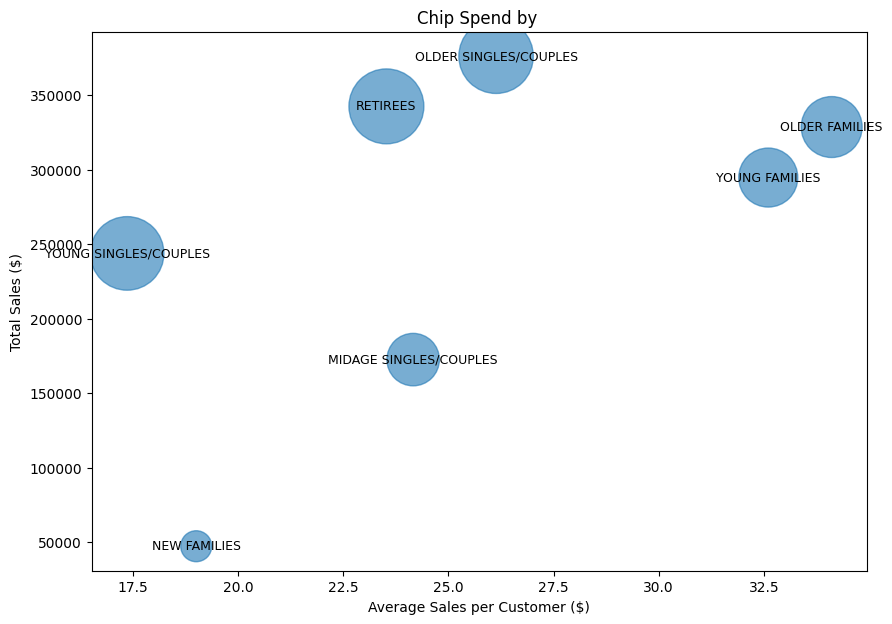

In [ ]:
import matplotlib.pyplot as plt
# Data
df_viz = spend_by_lifestage.reset_index()

plt.figure(figsize=(10, 7))

plt.scatter(
    df_viz['average_sales_per_customer'],
    df_viz['total_sales'],
    s=df_viz['num_customers'] / 5, # scale bubble size
    alpha=0.6
)
for i in range(len(df_viz)):
    plt.text(
        df_viz['average_sales_per_customer'][i],
        df_viz['total_sales'][i],
        df_viz['LIFESTAGE'][i],
        fontsize=9,
        ha='center',
        va='center'
    )
plt.xlabel('Average Sales per Customer ($)')
plt.ylabel('Total Sales ($)')
plt.title('Chip Spend by ')

plt.show()

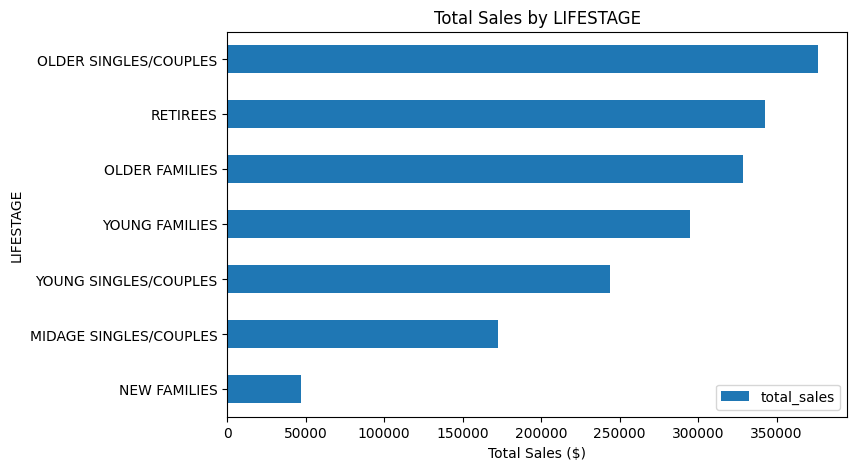

In [ ]:
df_viz.sort_values('total_sales').plot(
    x='LIFESTAGE',
    y='total_sales',
    kind='barh',
    figsize=(8,5),
)
plt.xlabel('Total Sales ($)')
plt.title('Total Sales by LIFESTAGE')
plt.show()

### 6.2.A.1 Spend by LIFESTAGE

To understand how chip spend varies across different life stages, total and average spend metrics were analysed by customer lifestage.

**Key Observations:**
- **Older Singles/Couples** contribute the highest total chip sales, followed by **Retirees** and **Older Families**.
- **Older Families** and **Young Families** exhibit the highest average spend per customer, despite having smaller customer bases than Older Singles/Couples.
- **Young Singles/Couples** have a relatively large customer base but contribute lower total sales and lower average spend per customer.
- Total sales contribution varies across lifestages and does not directly align with average spend per customer, indicating that both customer base size and per-customer spend influence overall revenue.

These observations suggest that different lifestages contribute to category revenue through different mechanisms, which will be further explored using additional segmentation lenses in subsequent analysis.


### Spend by PREMIUM_CUSTOMER


To understand how price orientation (Budget / Mainstream / Premium) influences:

* total chip sales contribution
* average customer value
* average basket value

This directly informs pricing, promotions, and shelf positioning decisions.

In [ ]:
spend_by_premium = (
    merged_data
    .groupby('PREMIUM_CUSTOMER')
    .agg(
        total_sales=('TOT_SALES', 'sum'),
        average_sales_per_customer = ('TOT_SALES', 'mean'),
        num_customers = ('LYLTY_CARD_NBR', 'nunique')
)
)
# Correct average spend per customer
spend_by_premium['average_sales_per_customer'] = (
    spend_by_premium['total_sales'] / 
    spend_by_premium['num_customers']
)
spend_by_premium.sort_values('total_sales', ascending=False)

,total_sales,average_sales_per_customer,num_customers
PREMIUM_CUSTOMER,,,
Mainstream,700865.40,24.391501,28734
Budget,631406.85,26.302043,24006
Premium,472905.45,25.497679,18547


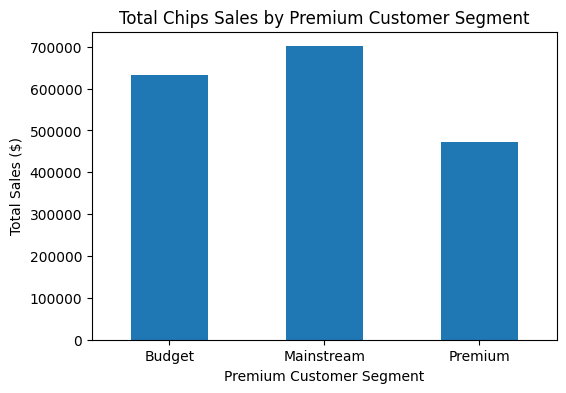

In [ ]:
# visualization 
spend_by_premium['total_sales'].plot(
    kind='bar',
    figsize=(6, 4),
    title='Total Chips Sales by Premium Customer Segment'
)
plt.xlabel('Premium Customer Segment')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=0)
plt.show()

### 6.2.A.2 Spend by PREMIUM_CUSTOMER

To assess how price orientation influences chip purchasing behaviour, spend-related metrics were analysed by premium customer segment.

**Key Observations:**
- The **Mainstream** segment contributes the highest total chip sales, followed by **Budget**, with **Premium** contributing the lowest total sales.
- Despite contributing lower total sales, **Premium** customers have the highest average spend per customer.
- **Mainstream** customers have the lowest average spend per customer but contribute the highest total sales due to their larger customer base.
- Total sales contribution across premium segments is driven by a combination of customer base size and average spend per customer rather than either factor alone.

These observations indicate that premium orientation affects purchasing behaviour differently across segments and should be analysed jointly with other behavioural dimensions in subsequent sections.


#### Spend by LIFESTAGE x PREMIUM_CUSTOMER
 
 Objective 

To identify which specific customer segment combinations (life stage × premium orientation) are the true revenue drivers, and to understand whether high contribution comes from:

* segment size,
* higher spend per customer,
* or a combination of both.

This is the cut that breaks stereotypes and produces commercially useful insight.

In [ ]:
spend_by_life_premium = (
    merged_data
    .groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])
    .agg(
        total_sales=('TOT_SALES', 'sum'),
        num_customers = ('LYLTY_CARD_NBR', 'nunique'),
        avg_sales_per_transaction= ('TOT_SALES', 'mean')
    )
    .reset_index()
)
# Correct average spend per customer
spend_by_life_premium['average_sales_per_customer'] = (
    spend_by_life_premium['total_sales'] / spend_by_life_premium['num_customers']
)
# Sort by total sales to see revenue drivers
spend_by_life_premium_sorted = spend_by_life_premium.sort_values(
    'total_sales', ascending=False
)
spend_by_life_premium_sorted

,LIFESTAGE,PREMIUM_CUSTOMER,total_sales,num_customers,avg_sales_per_transaction,average_sales_per_customer
6,OLDER FAMILIES,Budget,156863.75,4611,7.291241,34.019464
19,YOUNG SINGLES/COUPLES,Mainstream,147582.20,7917,7.551279,18.641177
13,RETIREES,Mainstream,145168.95,6358,7.269352,22.832487
15,YOUNG FAMILIES,Budget,129717.95,3953,7.302705,32.815065
9,OLDER SINGLES/COUPLES,Budget,127833.60,4849,7.444305,26.362879
10,OLDER SINGLES/COUPLES,Mainstream,124648.50,4858,7.306049,25.658399
11,OLDER SINGLES/COUPLES,Premium,123537.55,4682,7.459997,26.385636
12,RETIREES,Budget,105916.30,4385,7.445786,24.154230
7,OLDER FAMILIES,Mainstream,96413.55,2788,7.281440,34.581618
14,RETIREES,Premium,91296.65,3812,7.461315,23.949803


### Visualization 1: (Primary): HeatMap - Total Sales

**Where does the money actually come from?**


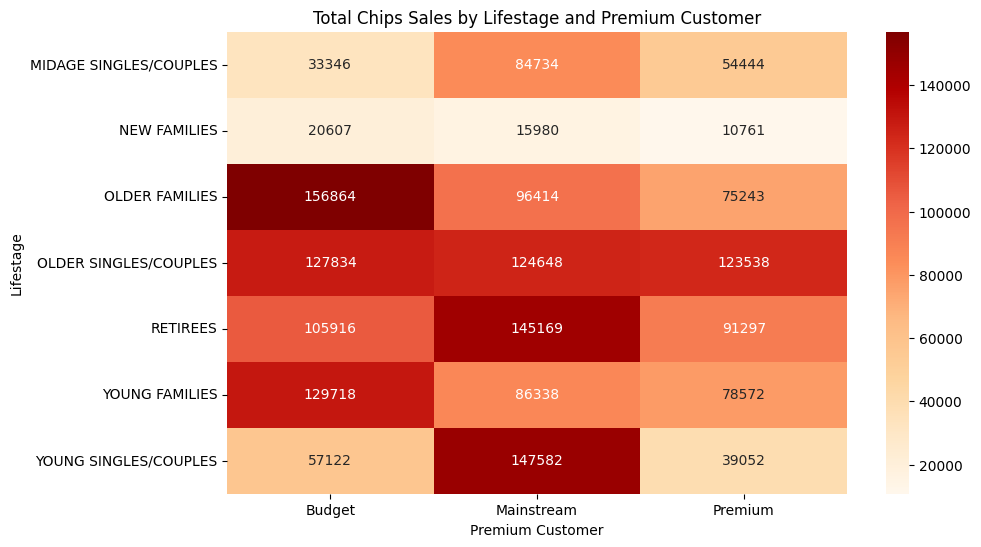

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
pivot_sales = spend_by_life_premium.pivot(
    index='LIFESTAGE',
    columns='PREMIUM_CUSTOMER',
    values='total_sales'
)
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_sales,
    annot=True,
    fmt=".0f",
    cmap="OrRd"
)
plt.title('Total Chips Sales by Lifestage and Premium Customer')
plt.xlabel('Premium Customer')
plt.ylabel('Lifestage')
plt.show()
# from the visuualization top three drivers are:
# 1. OLDER FAMILIES - BUDGET
# 2. YOUNG SINGLES/COUPLES - MAINSTREAM
# 3. RETIREES - MAINSTREAM

### Visualization 2: Avg Sales per Customer (Segement Value)

**Which segment combination are the most valuable per customer?**

this complements the heatmap by sperating scale vs intensity.

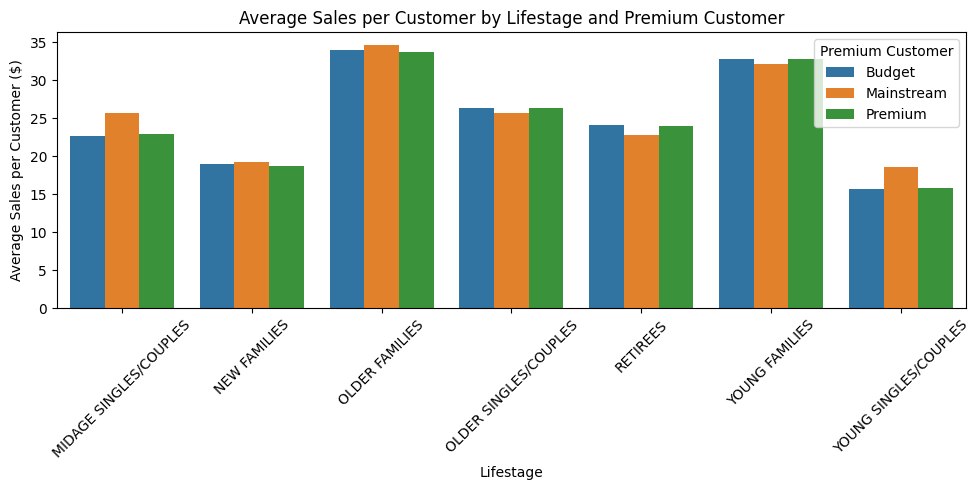

In [ ]:
plt.figure(figsize=(10, 5))

sns.barplot(
    data=spend_by_life_premium,
    x='LIFESTAGE',
    y='average_sales_per_customer',
    hue='PREMIUM_CUSTOMER'
)

plt.title('Average Sales per Customer by Lifestage and Premium Customer')
plt.ylabel('Average Sales per Customer ($)')
plt.xlabel('Lifestage')
plt.xticks(rotation=45)
plt.legend(title='Premium Customer')
plt.tight_layout()
plt.show()
# OLDERS FAMILIES AND YOUNG FAMILIES HAVE HIGHEST AVERAGE SALES PER CUSTOMER ACROSS ALL SEGMENTS OF AVERAGE SALES PER CUSTOMER

### Visualization 3: Bubble Chart - Scale vs Value 

In [ ]:
# Create a normalized size column
min_size = 200
max_size = 1200

cust_min = spend_by_life_premium['num_customers'].min()
cust_max = spend_by_life_premium['num_customers'].max()

spend_by_life_premium['bubble_size'] = (
    (spend_by_life_premium['num_customers'] - cust_min)
    / (cust_max - cust_min)
) * (max_size - min_size) + min_size
color_map = {
    "Budget": "#1f77b4",
    "Mainstream": "#ff7f0e",
    "Premium": "#2ca02c"
}



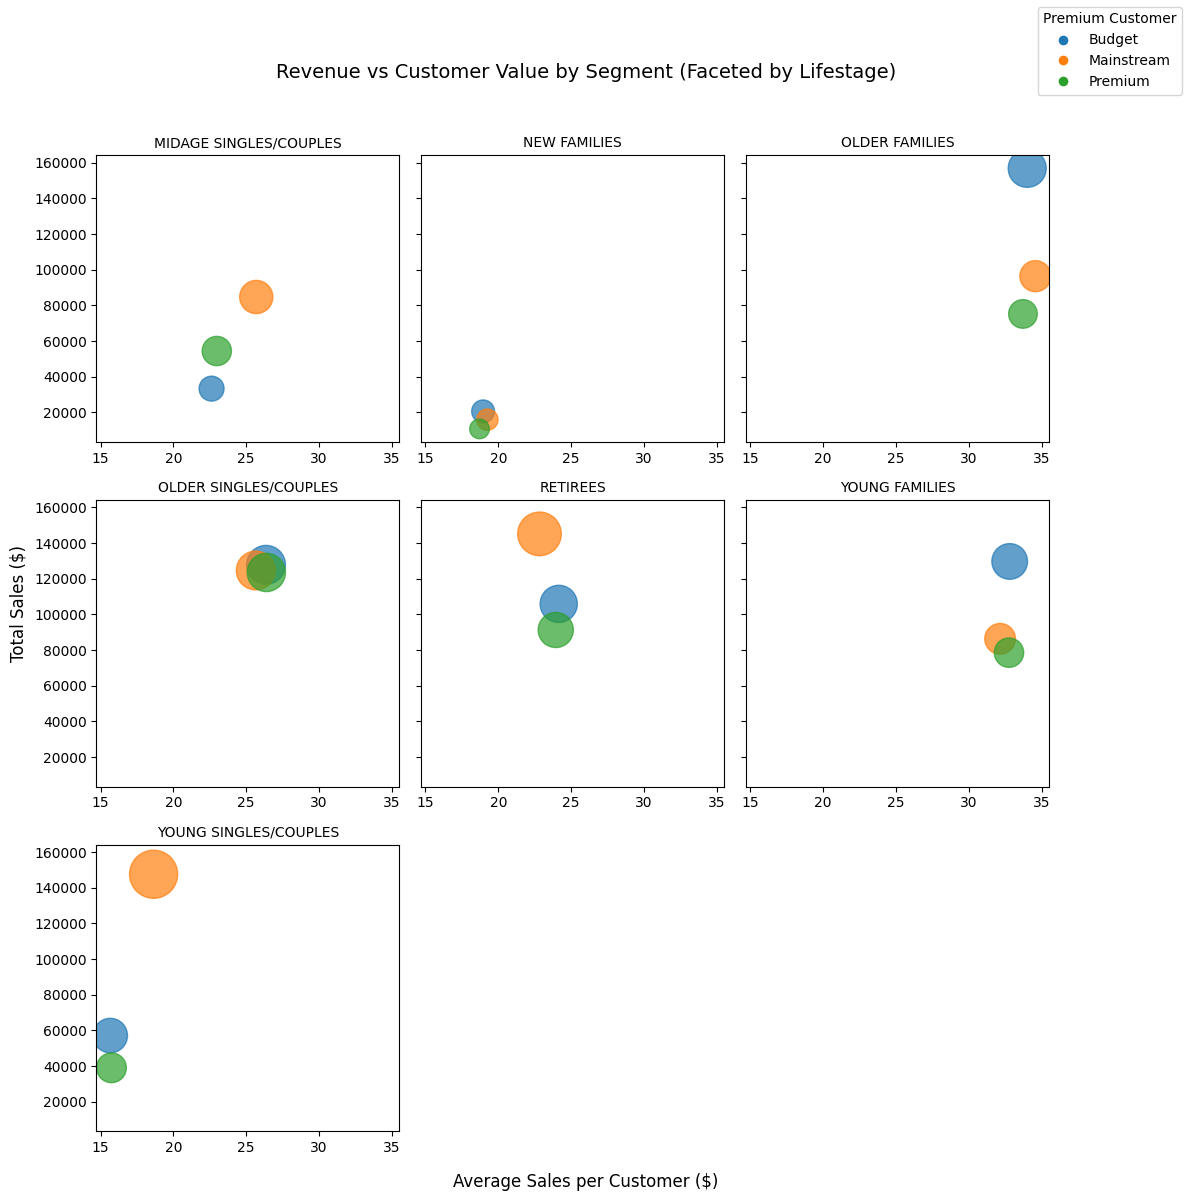

In [ ]:
import matplotlib.pyplot as plt

lifestages = spend_by_life_premium['LIFESTAGE'].unique()

fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)
axes = axes.flatten()
for ax in axes:
    ax.set_xticks([15, 20, 25, 30, 35])

for ax, stage in zip(axes, lifestages):
    subset = spend_by_life_premium[
        spend_by_life_premium['LIFESTAGE'] == stage
    ]
    
    ax.scatter(
        subset['average_sales_per_customer'],
        subset['total_sales'],
        s=subset['bubble_size'],              # DIRECT size usage
        c=subset['PREMIUM_CUSTOMER'].map(color_map),
        alpha=0.7
    )
    
    ax.set_title(stage, fontsize=10)

# Remove empty subplots
for ax in axes[len(lifestages):]:
    ax.axis('off')

fig.supxlabel("Average Sales per Customer ($)")
fig.supylabel("Total Sales ($)")
fig.suptitle(
    "Revenue vs Customer Value by Segment (Faceted by Lifestage)",
    fontsize=14,
    y=0.95
)

# Custom legend (color only)
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Budget',
           markerfacecolor=color_map['Budget'], markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Mainstream',
           markerfacecolor=color_map['Mainstream'], markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Premium',
           markerfacecolor=color_map['Premium'], markersize=8)
]

fig.legend(
    handles=legend_elements,
    title="Premium Customer",
    loc="upper right"
)
# Re-enable x-axis tick labels for all subplots
for ax in axes:
    ax.tick_params(axis='x', labelbottom=True)

plt.tight_layout(rect=[0, 0, 0.9, 0.93])
plt.show()


### Section 6.2.A — Spend Analysis by Customer Segment

### Objective
To understand how chip revenue is distributed across customer segments and identify whether total sales are driven primarily by:
- the **number of customers**, or  
- the **value of each customer**,  

across **LIFESTAGE** and **PREMIUM_CUSTOMER** segments.

---

### Spend by LIFESTAGE — Key Observations

- **Older Singles/Couples** are the largest contributors to total chip sales, despite not having the highest average spend per customer.
- **Older Families** and **Young Families** exhibit the highest average spend per customer, indicating higher per-household chip consumption.
- **Young Singles/Couples**, when viewed at the lifestage level alone, are not major total revenue drivers, largely due to lower average spend per customer.
- **New Families** contribute the least to both total sales and average spend, making them a low-impact segment at a category level.

📌 **Key takeaway:**  
Total sales at the lifestage level are influenced by both customer count and per-customer spend; no single factor alone explains revenue dominance.

---

### Spend by PREMIUM_CUSTOMER — Key Observations

- **Mainstream customers** generate the highest total chip sales, outperforming both Budget and Premium segments.
- **Premium customers** show the highest average spend per customer, as expected, but their smaller population limits total revenue contribution.
- **Budget customers** contribute significantly to total sales due to scale, despite lower per-customer spend.

📌 **Key takeaway:**  
Premium behaviour increases customer value, but **scale remains critical** for revenue dominance.

---

### Spend by LIFESTAGE × PREMIUM_CUSTOMER — Integrated View

Using **faceted bubble charts**:
- **Bubble size:** number of customers  
- **X-axis:** average sales per customer  
- **Y-axis:** total sales  

#### Key Patterns Identified

**Top revenue-driving segments:**
- Older Families – Budget  
- Young Singles/Couples – Mainstream  
- Retirees – Mainstream  

**Older Families**
- Budget customers dominate total sales due to scale.
- Premium customers have high per-customer spend but a smaller presence.

**Young Singles/Couples**
- Mainstream customers are a major revenue driver, despite the lifestage not standing out in aggregate analysis.
- Indicates a strong mainstream positioning effect.

**Retirees**
- Mainstream segment clearly dominates, challenging assumptions that retirees are primarily budget-focused.

**New Families**
- All premium tiers show low revenue contribution.
- Limited strategic upside for the chip category.

📌 **Key takeaway:**  
High-revenue segments emerge **only when lifestage and premium tier are analysed together**. Aggregate views mask critical revenue drivers.


#### Volume Vs Value Drivers

#### Units per Transaction (Volume Intensity)

In [ ]:
units_per_txn = (
    merged_data
    .groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])
    .agg(
        avg_units_per_txn = ('PROD_QTY', 'mean'),
        median_units_per_txn = ('PROD_QTY', 'median')
    )
    .reset_index()
)
units_per_txn.sort_values('avg_units_per_txn', ascending=False)

,LIFESTAGE,PREMIUM_CUSTOMER,avg_units_per_txn,median_units_per_txn
7,OLDER FAMILIES,Mainstream,1.948795,2.0
8,OLDER FAMILIES,Premium,1.945496,2.0
6,OLDER FAMILIES,Budget,1.945384,2.0
16,YOUNG FAMILIES,Mainstream,1.941408,2.0
15,YOUNG FAMILIES,Budget,1.941226,2.0
17,YOUNG FAMILIES,Premium,1.938149,2.0
9,OLDER SINGLES/COUPLES,Budget,1.914920,2.0
11,OLDER SINGLES/COUPLES,Premium,1.913949,2.0
1,MIDAGE SINGLES/COUPLES,Mainstream,1.911942,2.0
10,OLDER SINGLES/COUPLES,Mainstream,1.911201,2.0


In [97]:
units_per_customer = (
    merged_data
    .groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])
    .agg(
        total_units = ('PROD_QTY', 'sum'),
        num_customers = ('LYLTY_CARD_NBR', 'nunique')
    )
    .reset_index()
)
units_per_customer['avg_units_per_customer'] = (
    units_per_customer['total_units'] / 
    units_per_customer['num_customers']
)
units_per_customer.sort_values(
    'avg_units_per_customer', ascending=False
)

,LIFESTAGE,PREMIUM_CUSTOMER,total_units,num_customers,avg_units_per_customer
7,OLDER FAMILIES,Mainstream,25804,2788,9.255380
6,OLDER FAMILIES,Budget,41853,4611,9.076773
8,OLDER FAMILIES,Premium,20239,2231,9.071717
15,YOUNG FAMILIES,Budget,34482,3953,8.722995
17,YOUNG FAMILIES,Premium,20901,2398,8.716013
16,YOUNG FAMILIES,Mainstream,23194,2685,8.638361
9,OLDER SINGLES/COUPLES,Budget,32883,4849,6.781398
11,OLDER SINGLES/COUPLES,Premium,31695,4682,6.769543
10,OLDER SINGLES/COUPLES,Mainstream,32607,4858,6.712021
1,MIDAGE SINGLES/COUPLES,Mainstream,21213,3298,6.432080


#### Pack Size Behaviour by Segment

In [ ]:
pack_size_by_segment = (
    merged_data
    .groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])
    .agg(
        avg_pack_size = ('PACK_SIZE(GRAMS)', 'mean'),
        median_pack_size = ('PACK_SIZE(GRAMS)', 'median')
    )
    .reset_index()
)
pack_size_by_segment.sort_values(
    'avg_pack_size', ascending=False
)

,LIFESTAGE,PREMIUM_CUSTOMER,avg_pack_size,median_pack_size
19,YOUNG SINGLES/COUPLES,Mainstream,178.344249,170.0
1,MIDAGE SINGLES/COUPLES,Mainstream,177.898693,170.0
11,OLDER SINGLES/COUPLES,Premium,176.485568,170.0
12,RETIREES,Budget,176.395641,170.0
14,RETIREES,Premium,176.368421,170.0
4,NEW FAMILIES,Mainstream,175.629748,170.0
6,OLDER FAMILIES,Budget,175.546342,170.0
15,YOUNG FAMILIES,Budget,175.459720,170.0
9,OLDER SINGLES/COUPLES,Budget,175.334673,170.0
5,NEW FAMILIES,Premium,175.245296,170.0


### Section 6.3 — Volume vs Value Drivers

### Objective

To identify the underlying mechanisms driving differences in chip spend across customer segments by decomposing spend into:

* per-transaction volume,
* cumulative volume per customer, and
* pack size preference.

This section isolates how customers generate spend, not who generates the most spend.

### 6.3.1 Units per Transaction

* Median units per transaction is 2 units across all segments.
* Average units per transaction varies narrowly between ~1.80 and ~1.95.
* Family segments purchase marginally more units per visit than singles, but the difference is small.
* Premium tier does not materially affect units purchased per transaction.

**Key takeaway:** Units purchased per shopping trip are highly consistent across segments and do not explain observed spend differences.

### 6.3.2 Units per Customer

* Strong separation is observed by lifestage:
   * Older Families: ~9.1–9.3 units per customer
   * Young Families: ~8.6–8.7 units per customer
   * Older Singles / Retirees: ~6.0–6.8 units per customer
   * Young Singles/Couples: ~4.2–4.6 units per customer
* Differences across premium tiers within a lifestage are minimal.

**Key takeaway:** Higher chip spend among family segments is driven by greater cumulative purchasing over time, not by per-visit behaviour.

### 6.3.3 Pack Size Behaviour

* Median pack size is 170g for all segments.
* Average pack size ranges narrowly between ~173g and ~178g.
* No meaningful differences are observed by lifestage or premium tier.

**Key takeaway:** Pack size preference is uniform across customer segments and does not explain volume or spend differences.

### Overall Conclusion (Section 6.3)

Differences in chip spend across customer segments are driven almost entirely by purchase frequency over time, rather than:

* buying more units per visit, or
* choosing larger pack sizes.

### Brand Share by Total Sales

**Objective**

To Identify which brands dominate revenue contribution within each customer segement and whether different segments show materially different brand preferences.

Metrics to Compute:

At the LIFESTAGE x PREMIUM_CUSTOMER x BRAND level:

1. Total Sales --> sum(TOT_SALES)

2. Brand Share of Segment Sales
    brand sales/total sales of the segment 

In [ ]:
brand_sales = (
    merged_data
    .groupby(['BRAND', 'LIFESTAGE', 'PREMIUM_CUSTOMER'])
    .agg(
        total_sales = ('TOT_SALES', 'sum'),
    )
    .reset_index()
)
# Compute total sales per segment
segment_totals = (
    brand_sales
    .groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])
    .agg(
        segment_total_sales = ('total_sales', 'sum')
    )
    .reset_index()
)
#Merge back to compute share 
brand_sales = brand_sales.merge(
    segment_totals,
    on=['LIFESTAGE', 'PREMIUM_CUSTOMER'],
    how='left'
)
brand_sales['brand_sales_share'] = (
    brand_sales['total_sales'] / brand_sales['segment_total_sales']
)
brand_sales.sort_values(
    ['LIFESTAGE', 'PREMIUM_CUSTOMER', 'brand_sales_share'],
    ascending=[True, True, False]
).head(20)

,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,total_sales,segment_total_sales,brand_sales_share
189,Kettle,MIDAGE SINGLES/COUPLES,Budget,6736.2,33345.7,0.202011
105,Doritos,MIDAGE SINGLES/COUPLES,Budget,4291.0,33345.7,0.128682
273,Smiths,MIDAGE SINGLES/COUPLES,Budget,4056.3,33345.7,0.121644
231,Pringles,MIDAGE SINGLES/COUPLES,Budget,3159.8,33345.7,0.094759
168,Infuzions,MIDAGE SINGLES/COUPLES,Budget,1957.8,33345.7,0.058712
252,Red Rock Deli,MIDAGE SINGLES/COUPLES,Budget,1744.5,33345.7,0.052316
315,Thins,MIDAGE SINGLES/COUPLES,Budget,1673.1,33345.7,0.050174
357,Twisties,MIDAGE SINGLES/COUPLES,Budget,1505.4,33345.7,0.045145
336,Tostitos,MIDAGE SINGLES/COUPLES,Budget,1403.6,33345.7,0.042092
84,Cobs,MIDAGE SINGLES/COUPLES,Budget,1311.0,33345.7,0.039315


In [ ]:
top_brands_per_segment = (
    brand_sales
    .sort_values(
        ['LIFESTAGE', 'PREMIUM_CUSTOMER', 'brand_sales_share'],
        ascending=[True, True, False]
    )
    .groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])
    .head()
)
top_brands_per_segment

,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,total_sales,segment_total_sales,brand_sales_share
189,Kettle,MIDAGE SINGLES/COUPLES,Budget,6736.2,33345.7,0.202011
105,Doritos,MIDAGE SINGLES/COUPLES,Budget,4291.0,33345.7,0.128682
273,Smiths,MIDAGE SINGLES/COUPLES,Budget,4056.3,33345.7,0.121644
231,Pringles,MIDAGE SINGLES/COUPLES,Budget,3159.8,33345.7,0.094759
168,Infuzions,MIDAGE SINGLES/COUPLES,Budget,1957.8,33345.7,0.058712
...,...,...,...,...,...,...
209,Kettle,YOUNG SINGLES/COUPLES,Premium,7711.4,39052.3,0.197463
293,Smiths,YOUNG SINGLES/COUPLES,Premium,5103.9,39052.3,0.130694
125,Doritos,YOUNG SINGLES/COUPLES,Premium,4257.6,39052.3,0.109023
251,Pringles,YOUNG SINGLES/COUPLES,Premium,3640.8,39052.3,0.093229


In [ ]:
top_brands_per_segment[['LIFESTAGE', 'PREMIUM_CUSTOMER']].drop_duplicates().shape


(21, 2)

In [ ]:
top_brands_per_segment[['LIFESTAGE', 'PREMIUM_CUSTOMER']].drop_duplicates()


,LIFESTAGE,PREMIUM_CUSTOMER
189,MIDAGE SINGLES/COUPLES,Budget
190,MIDAGE SINGLES/COUPLES,Mainstream
191,MIDAGE SINGLES/COUPLES,Premium
192,NEW FAMILIES,Budget
193,NEW FAMILIES,Mainstream
194,NEW FAMILIES,Premium
195,OLDER FAMILIES,Budget
196,OLDER FAMILIES,Mainstream
197,OLDER FAMILIES,Premium
198,OLDER SINGLES/COUPLES,Budget


In [ ]:
top_brands_per_segment[
    (top_brands_per_segment['LIFESTAGE'] == 'OLDER FAMILIES') &
    (top_brands_per_segment['PREMIUM_CUSTOMER'] == 'Budget')
]


,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,total_sales,segment_total_sales,brand_sales_share
195,Kettle,OLDER FAMILIES,Budget,32058.00,156863.75,0.204368
279,Smiths,OLDER FAMILIES,Budget,20917.90,156863.75,0.133351
111,Doritos,OLDER FAMILIES,Budget,18555.55,156863.75,0.118291
237,Pringles,OLDER FAMILIES,Budget,14300.50,156863.75,0.091165
258,Red Rock Deli,OLDER FAMILIES,Budget,9379.20,156863.75,0.059792


In [ ]:
top_brands_per_segment[
    (top_brands_per_segment['LIFESTAGE'] == 'OLDER FAMILIES') &
    (top_brands_per_segment['PREMIUM_CUSTOMER'] == 'Mainstream')
]


,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,total_sales,segment_total_sales,brand_sales_share
196,Kettle,OLDER FAMILIES,Mainstream,19420.20,96413.55,0.201426
280,Smiths,OLDER FAMILIES,Mainstream,12448.10,96413.55,0.129112
112,Doritos,OLDER FAMILIES,Mainstream,11518.35,96413.55,0.119468
238,Pringles,OLDER FAMILIES,Mainstream,8939.20,96413.55,0.092717
259,Red Rock Deli,OLDER FAMILIES,Mainstream,5845.20,96413.55,0.060626


In [ ]:
top_brands_per_segment[
    (top_brands_per_segment['LIFESTAGE'] == 'OLDER FAMILIES') &
    (top_brands_per_segment['PREMIUM_CUSTOMER'] == 'Premium')
]


,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,total_sales,segment_total_sales,brand_sales_share
197,Kettle,OLDER FAMILIES,Premium,14505.8,75242.6,0.192787
281,Smiths,OLDER FAMILIES,Premium,10187.1,75242.6,0.135390
113,Doritos,OLDER FAMILIES,Premium,8460.0,75242.6,0.112436
239,Pringles,OLDER FAMILIES,Premium,7344.5,75242.6,0.097611
260,Red Rock Deli,OLDER FAMILIES,Premium,4644.3,75242.6,0.061724


In [ ]:
top_brands_per_segment[
    (top_brands_per_segment['LIFESTAGE'] == 'YOUNG FAMILIES') &
    (top_brands_per_segment['PREMIUM_CUSTOMER'] == 'Budget')
]


,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,total_sales,segment_total_sales,brand_sales_share
204,Kettle,YOUNG FAMILIES,Budget,26369.60,129717.95,0.203284
288,Smiths,YOUNG FAMILIES,Budget,16738.60,129717.95,0.129038
120,Doritos,YOUNG FAMILIES,Budget,16078.05,129717.95,0.123946
246,Pringles,YOUNG FAMILIES,Budget,12065.70,129717.95,0.093015
267,Red Rock Deli,YOUNG FAMILIES,Budget,7455.30,129717.95,0.057473


In [ ]:
top_brands_per_segment[
    (top_brands_per_segment['LIFESTAGE'] == 'YOUNG FAMILIES') &
    (top_brands_per_segment['PREMIUM_CUSTOMER'] == 'Premium')
]


,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,total_sales,segment_total_sales,brand_sales_share
206,Kettle,YOUNG FAMILIES,Premium,16614.2,78571.7,0.211453
290,Smiths,YOUNG FAMILIES,Premium,9757.8,78571.7,0.124190
122,Doritos,YOUNG FAMILIES,Premium,9061.9,78571.7,0.115333
248,Pringles,YOUNG FAMILIES,Premium,7244.6,78571.7,0.092204
269,Red Rock Deli,YOUNG FAMILIES,Premium,4754.1,78571.7,0.060507


In [ ]:
top_brands_per_segment[
    (top_brands_per_segment['LIFESTAGE'] == 'YOUNG FAMILIES') &
    (top_brands_per_segment['PREMIUM_CUSTOMER'] == 'Mainstream')
]


,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,total_sales,segment_total_sales,brand_sales_share
205,Kettle,YOUNG FAMILIES,Mainstream,17049.20,86338.25,0.197470
289,Smiths,YOUNG FAMILIES,Mainstream,11754.90,86338.25,0.136149
121,Doritos,YOUNG FAMILIES,Mainstream,10108.55,86338.25,0.117081
247,Pringles,YOUNG FAMILIES,Mainstream,8188.10,86338.25,0.094837
268,Red Rock Deli,YOUNG FAMILIES,Mainstream,5106.60,86338.25,0.059146


In [ ]:
top_brands_per_segment[
    (top_brands_per_segment['LIFESTAGE'] == 'RETIREES') &
    (top_brands_per_segment['PREMIUM_CUSTOMER'] == 'Budget')
]


,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,total_sales,segment_total_sales,brand_sales_share
201,Kettle,RETIREES,Budget,24340.0,105916.3,0.229804
117,Doritos,RETIREES,Budget,14244.4,105916.3,0.134487
285,Smiths,RETIREES,Budget,11928.1,105916.3,0.112618
243,Pringles,RETIREES,Budget,10726.3,105916.3,0.101271
180,Infuzions,RETIREES,Budget,5436.0,105916.3,0.051324


In [ ]:
top_brands_per_segment[
    (top_brands_per_segment['LIFESTAGE'] == 'RETIREES') &
    (top_brands_per_segment['PREMIUM_CUSTOMER'] == 'Mainstream')
]

,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,total_sales,segment_total_sales,brand_sales_share
202,Kettle,RETIREES,Mainstream,31652.40,145168.95,0.218038
118,Doritos,RETIREES,Mainstream,18531.55,145168.95,0.127655
286,Smiths,RETIREES,Mainstream,16779.00,145168.95,0.115583
244,Pringles,RETIREES,Mainstream,14781.50,145168.95,0.101823
181,Infuzions,RETIREES,Mainstream,8186.20,145168.95,0.056391


In [ ]:
top_brands_per_segment[
    (top_brands_per_segment['LIFESTAGE'] == 'RETIREES') &
    (top_brands_per_segment['PREMIUM_CUSTOMER'] == 'Premium')
]

,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,total_sales,segment_total_sales,brand_sales_share
203,Kettle,RETIREES,Premium,20922.40,91296.65,0.229169
119,Doritos,RETIREES,Premium,11685.05,91296.65,0.127990
287,Smiths,RETIREES,Premium,10301.50,91296.65,0.112835
245,Pringles,RETIREES,Premium,9390.60,91296.65,0.102858
182,Infuzions,RETIREES,Premium,5276.80,91296.65,0.057798


In [ ]:
top_brands_per_segment[
    (top_brands_per_segment['LIFESTAGE'] == 'OLDER SINGLES/COUPLES') &
    (top_brands_per_segment['PREMIUM_CUSTOMER'] == 'Budget')
]

,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,total_sales,segment_total_sales,brand_sales_share
198,Kettle,OLDER SINGLES/COUPLES,Budget,29066.4,127833.6,0.227377
114,Doritos,OLDER SINGLES/COUPLES,Budget,15806.6,127833.6,0.123650
282,Smiths,OLDER SINGLES/COUPLES,Budget,14820.6,127833.6,0.115937
240,Pringles,OLDER SINGLES/COUPLES,Budget,13131.3,127833.6,0.102722
177,Infuzions,OLDER SINGLES/COUPLES,Budget,7256.0,127833.6,0.056761


In [ ]:
top_brands_per_segment[
    (top_brands_per_segment['LIFESTAGE'] == 'OLDER SINGLES/COUPLES') &
    (top_brands_per_segment['PREMIUM_CUSTOMER'] == 'Mainstream')
]

,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,total_sales,segment_total_sales,brand_sales_share
199,Kettle,OLDER SINGLES/COUPLES,Mainstream,26852.8,124648.5,0.215428
115,Doritos,OLDER SINGLES/COUPLES,Mainstream,16226.6,124648.5,0.130179
283,Smiths,OLDER SINGLES/COUPLES,Mainstream,14580.7,124648.5,0.116975
241,Pringles,OLDER SINGLES/COUPLES,Mainstream,12136.0,124648.5,0.097362
178,Infuzions,OLDER SINGLES/COUPLES,Mainstream,6716.4,124648.5,0.053883


In [ ]:
top_brands_per_segment[
    (top_brands_per_segment['LIFESTAGE'] == 'OLDER SINGLES/COUPLES') &
    (top_brands_per_segment['PREMIUM_CUSTOMER'] == 'Premium')
]

,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,total_sales,segment_total_sales,brand_sales_share
200,Kettle,OLDER SINGLES/COUPLES,Premium,27943.40,123537.55,0.226194
116,Doritos,OLDER SINGLES/COUPLES,Premium,16042.85,123537.55,0.129862
284,Smiths,OLDER SINGLES/COUPLES,Premium,14338.30,123537.55,0.116064
242,Pringles,OLDER SINGLES/COUPLES,Premium,12335.80,123537.55,0.099855
179,Infuzions,OLDER SINGLES/COUPLES,Premium,6748.20,123537.55,0.054625


In [ ]:
top_brands_per_segment[
    (top_brands_per_segment['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') &
    (top_brands_per_segment['PREMIUM_CUSTOMER'] == 'Budget')
]

,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,total_sales,segment_total_sales,brand_sales_share
207,Kettle,YOUNG SINGLES/COUPLES,Budget,11106.0,57122.1,0.194426
291,Smiths,YOUNG SINGLES/COUPLES,Budget,7373.1,57122.1,0.129076
123,Doritos,YOUNG SINGLES/COUPLES,Budget,6830.0,57122.1,0.119568
249,Pringles,YOUNG SINGLES/COUPLES,Budget,5649.9,57122.1,0.098909
270,Red Rock Deli,YOUNG SINGLES/COUPLES,Budget,3362.4,57122.1,0.058863


In [ ]:
top_brands_per_segment[
    (top_brands_per_segment['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') &
    (top_brands_per_segment['PREMIUM_CUSTOMER'] == 'Mainstream')
]

,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,total_sales,segment_total_sales,brand_sales_share
208,Kettle,YOUNG SINGLES/COUPLES,Mainstream,35423.6,147582.2,0.240026
124,Doritos,YOUNG SINGLES/COUPLES,Mainstream,20925.9,147582.2,0.141791
250,Pringles,YOUNG SINGLES/COUPLES,Mainstream,16006.2,147582.2,0.108456
292,Smiths,YOUNG SINGLES/COUPLES,Mainstream,14958.9,147582.2,0.101360
187,Infuzions,YOUNG SINGLES/COUPLES,Mainstream,8749.4,147582.2,0.059285


In [ ]:
top_brands_per_segment[
    (top_brands_per_segment['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') &
    (top_brands_per_segment['PREMIUM_CUSTOMER'] == 'Premium')
]

,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,total_sales,segment_total_sales,brand_sales_share
209,Kettle,YOUNG SINGLES/COUPLES,Premium,7711.4,39052.3,0.197463
293,Smiths,YOUNG SINGLES/COUPLES,Premium,5103.9,39052.3,0.130694
125,Doritos,YOUNG SINGLES/COUPLES,Premium,4257.6,39052.3,0.109023
251,Pringles,YOUNG SINGLES/COUPLES,Premium,3640.8,39052.3,0.093229
272,Red Rock Deli,YOUNG SINGLES/COUPLES,Premium,2190.6,39052.3,0.056094


In [ ]:
top_brands_per_segment[
    (top_brands_per_segment['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') &
    (top_brands_per_segment['PREMIUM_CUSTOMER'] == 'Budget')
]

,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,total_sales,segment_total_sales,brand_sales_share
189,Kettle,MIDAGE SINGLES/COUPLES,Budget,6736.2,33345.7,0.202011
105,Doritos,MIDAGE SINGLES/COUPLES,Budget,4291.0,33345.7,0.128682
273,Smiths,MIDAGE SINGLES/COUPLES,Budget,4056.3,33345.7,0.121644
231,Pringles,MIDAGE SINGLES/COUPLES,Budget,3159.8,33345.7,0.094759
168,Infuzions,MIDAGE SINGLES/COUPLES,Budget,1957.8,33345.7,0.058712


In [ ]:
top_brands_per_segment[
    (top_brands_per_segment['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') &
    (top_brands_per_segment['PREMIUM_CUSTOMER'] == 'Mainstream')
]

,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,total_sales,segment_total_sales,brand_sales_share
190,Kettle,MIDAGE SINGLES/COUPLES,Mainstream,20231.80,84734.25,0.238768
106,Doritos,MIDAGE SINGLES/COUPLES,Mainstream,10714.65,84734.25,0.126450
274,Smiths,MIDAGE SINGLES/COUPLES,Mainstream,9874.10,84734.25,0.116530
232,Pringles,MIDAGE SINGLES/COUPLES,Mainstream,8177.00,84734.25,0.096502
169,Infuzions,MIDAGE SINGLES/COUPLES,Mainstream,4843.60,84734.25,0.057162


In [ ]:
top_brands_per_segment[
    (top_brands_per_segment['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') &
    (top_brands_per_segment['PREMIUM_CUSTOMER'] == 'Premium')
]

,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,total_sales,segment_total_sales,brand_sales_share
191,Kettle,MIDAGE SINGLES/COUPLES,Premium,11390.20,54443.85,0.209210
107,Doritos,MIDAGE SINGLES/COUPLES,Premium,6562.95,54443.85,0.120545
275,Smiths,MIDAGE SINGLES/COUPLES,Premium,6420.10,54443.85,0.117921
233,Pringles,MIDAGE SINGLES/COUPLES,Premium,5538.90,54443.85,0.101736
170,Infuzions,MIDAGE SINGLES/COUPLES,Premium,3032.00,54443.85,0.055690


In [ ]:
top_brands_per_segment[
    (top_brands_per_segment['LIFESTAGE'] == 'NEW FAMILIES') &
    (top_brands_per_segment['PREMIUM_CUSTOMER'] == 'Budget')
]

,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,total_sales,segment_total_sales,brand_sales_share
192,Kettle,NEW FAMILIES,Budget,4731.60,20607.45,0.229606
108,Doritos,NEW FAMILIES,Budget,2812.65,20607.45,0.136487
276,Smiths,NEW FAMILIES,Budget,2280.80,20607.45,0.110678
234,Pringles,NEW FAMILIES,Budget,2168.20,20607.45,0.105214
171,Infuzions,NEW FAMILIES,Budget,1238.00,20607.45,0.060075


In [ ]:
top_brands_per_segment[
    (top_brands_per_segment['LIFESTAGE'] == 'NEW FAMILIES') &
    (top_brands_per_segment['PREMIUM_CUSTOMER'] == 'Mainstream')
]

,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,total_sales,segment_total_sales,brand_sales_share
193,Kettle,NEW FAMILIES,Mainstream,3847.0,15979.7,0.240743
109,Doritos,NEW FAMILIES,Mainstream,2291.1,15979.7,0.143376
277,Smiths,NEW FAMILIES,Mainstream,1678.5,15979.7,0.105040
235,Pringles,NEW FAMILIES,Mainstream,1557.7,15979.7,0.097480
172,Infuzions,NEW FAMILIES,Mainstream,868.2,15979.7,0.054331


In [ ]:
top_brands_per_segment[
    (top_brands_per_segment['LIFESTAGE'] == 'NEW FAMILIES') &
    (top_brands_per_segment['PREMIUM_CUSTOMER'] == 'Premium')
]

,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,total_sales,segment_total_sales,brand_sales_share
194,Kettle,NEW FAMILIES,Premium,2267.6,10760.8,0.210728
110,Doritos,NEW FAMILIES,Premium,1324.6,10760.8,0.123095
278,Smiths,NEW FAMILIES,Premium,1193.7,10760.8,0.110930
236,Pringles,NEW FAMILIES,Premium,1172.9,10760.8,0.108997
173,Infuzions,NEW FAMILIES,Premium,589.8,10760.8,0.054810


In [ ]:
# Compute brand concentration metrics
brand_concentration = (
    top_brands_per_segment
    .groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])
    .agg(
        top_brand_share=('brand_sales_share', 'max'),
        top_3_brand_share=('brand_sales_share', lambda x: x.nlargest(3).sum())
    )
    .reset_index()
)

brand_concentration


,LIFESTAGE,PREMIUM_CUSTOMER,top_brand_share,top_3_brand_share
0,MIDAGE SINGLES/COUPLES,Budget,0.202011,0.452337
1,MIDAGE SINGLES/COUPLES,Mainstream,0.238768,0.481748
2,MIDAGE SINGLES/COUPLES,Premium,0.209210,0.447677
3,NEW FAMILIES,Budget,0.229606,0.476772
4,NEW FAMILIES,Mainstream,0.240743,0.489158
5,NEW FAMILIES,Premium,0.210728,0.444753
6,OLDER FAMILIES,Budget,0.204368,0.456010
7,OLDER FAMILIES,Mainstream,0.201426,0.450006
8,OLDER FAMILIES,Premium,0.192787,0.440613
9,OLDER SINGLES/COUPLES,Budget,0.227377,0.466963


In [ ]:
heatmap_data = brand_concentration.pivot(
    index='LIFESTAGE',
    columns='PREMIUM_CUSTOMER',
    values='top_3_brand_share'
)


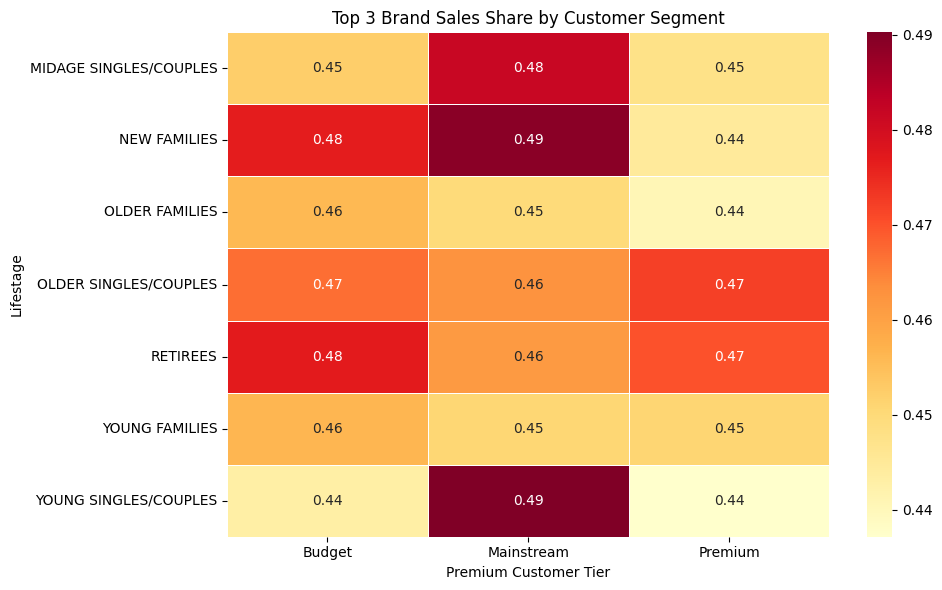

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="YlOrRd",
    linewidths=0.5
)

plt.title("Top 3 Brand Sales Share by Customer Segment")
plt.xlabel("Premium Customer Tier")
plt.ylabel("Lifestage")
plt.tight_layout()
plt.show()


## 6.4 Brand Preferences by Customer Segment

#### Objective

To assess whether different customer segments exhibit materially different brand preferences when purchasing chips, and to determine whether brand choice contributes meaningfully to differences in total sales across segments.

This section evaluates:

* Brand share by total sales
* Alignment between brand revenue and brand volume
* Degree of brand concentration vs fragmentation across segments

#### 6.4.1 Brand Share by Total Sales

Brand-level sales were aggregated within each LIFESTAGE × PREMIUM_CUSTOMER segment and converted into brand sales share.

Across all segments, the same set of brands consistently dominate total chip sales:

* Kettle
* Smiths
* Doritos
* Pringles

While absolute sales differ by segment size, the relative brand ranking remains stable across all customer groups.

#### 6.4.2 Brand Share by Volume

Brand-level volume analysis shows that brands generating the highest revenue are also the highest-volume brands.

There is no evidence of:

* brands that are high-volume but low-revenue, or
* brands that are premium-priced but niche in volume

This indicates that brand pricing differences are not a primary driver of segment-level sales variation.

#### 6.4.3 Brand Concentration vs Fragmentation

To assess brand concentration, two metrics were computed for each segment:

* Top Brand Share
* Top 3 Brand Share

Results show:

* Top brand share ranges narrowly between ~19%–24%
* Top 3 brand share consistently falls between ~45%–50% across all segments

A heatmap of Top 3 Brand Share confirms that:

* No segment is meaningfully more brand-concentrated than others
* Premium customers do not show stronger brand lock-in
* Family and singles segments display similar fragmentation patterns

#### Key Takeaway

Brand preferences are highly consistent across customer segments, and brand choice does not explain differences in spend, volume, or frequency. Chip category performance is therefore driven primarily by customer scale and purchasing behaviour rather than segment-specific brand loyalty.

## 6.5 Synthesis: What Drives Chip Sales by Customer Segment

### Objective

To integrate findings from spend, volume, frequency, pack size, and brand analyses to identify the key drivers of chip sales across customer segments.

### Key Drivers Assessed

The following potential drivers were evaluated:

* Customer scale (number of customers)
* Purchase frequency
* Units per transaction
* Units per customer
* Pack size choice
* Brand preference / loyalty
* Premium vs budget pricing behaviour

### Summary of Findings

#### Primary Drivers

* Purchase frequency is the strongest driver of chip sales.
* Units per customer vary significantly across segments and are driven by frequency, not basket size.
* Customer scale amplifies sales impact but does not explain performance on its own.

#### Secondary Driver

* Premium customers spend more per customer, but smaller segment size limits their contribution to total sales.

#### Non-Drivers

* Units per transaction are consistent (~2 units) across all segments.
* Pack size choice is uniform (median ~170g).
* Brand preferences are stable across segments, with top 3 brands accounting for ~45–50% of sales everywhere.

#### Integrated Insight

Differences in chip sales across customer segments are driven by how often customers buy chips, not by brand choice, pack size, or basket expansion.

High-performing segments succeed due to a combination of:

* larger customer bases
* higher repeat purchase behaviour

#### Outcome

This synthesis establishes that growth opportunities lie in increasing repeat engagement within large, high-volume segments rather than altering brand assortments or pack-size strategies.

---

## 7. Strategic Recommendations (Initial Findings)

### Objective

To provide early, data-backed guidance to support the upcoming chip category review.

### Recommendation 1: Focus on High-Frequency, High-Scale Segments

**Target segments:**

* Older Families
* Young Families
* Young Singles/Couples (Mainstream)

**Rationale:**

* These segments contribute the most to total sales.
* They exhibit higher units per customer driven by repeat purchases.
* Small increases in purchase frequency would have a meaningful impact on category revenue.

### Recommendation 2: Drive Growth Through Purchase Frequency

**Action focus:**

* Encourage more frequent chip purchases rather than larger baskets.

**Evidence:**

* Units per transaction are stable across all segments.
* Basket expansion and pack-size changes are unlikely to shift behaviour.

### Recommendation 3: Maintain a Broad, Competitive Brand Assortment

**Rationale:**

* Brand preferences are consistent across segments.
* No segment exhibits strong brand concentration or loyalty.
* Over-rationalisation risks reducing customer choice without improving performance.

### Recommendation 4: Use Premiumisation Selectively

**Rationale:**

* Premium customers spend more per customer but represent a smaller population.
* Premiumisation should support margin, not act as the primary growth lever.

### Final Note

Chip category performance is driven by frequency and reach, not by changing what customers buy. Strategic efforts should prioritise repeat engagement in high-volume segments.

In [ ]:
transaction_data1["YearMonth"] = transaction_data1["DATE"].dt.to_period("M").dt.to_timestamp()


In [ ]:
monthly_txns = (
    transaction_data1.groupby("YearMonth")["TXN_ID"]
      .nunique()
      .reset_index(name="Total_Transactions")
)


In [ ]:
monthly_txns = monthly_txns[
    (monthly_txns["YearMonth"] >= "2018-07-01") &
    (monthly_txns["YearMonth"] <= "2019-06-30")
]


In [ ]:
monthly_txns["Month"] = monthly_txns["YearMonth"].dt.strftime("%b %Y")

final_table = monthly_txns[["Month", "Total_Transactions"]]


In [ ]:
print(monthly_txns["YearMonth"].min())
print(monthly_txns["YearMonth"].max())


2018-07-01 00:00:00
2019-06-01 00:00:00


In [ ]:
final_table.to_csv("C:/Users/adith/quantium_data_analytics/data/monthly_chip_transactions.csv", index=False)


In [98]:
units_per_customer_data = units_per_customer[
    ['LIFESTAGE', 'PREMIUM_CUSTOMER', 'avg_units_per_customer']
]

In [99]:
units_per_customer_data.to_csv("C:/Users/adith/quantium_data_analytics/data/avg_units_per_customer_by_segment.csv", index=False)